In [17]:

import yfinance as yf
import pandas as pd
import numpy as np
import os
from typing import List, Tuple

import seaborn as sns
import matplotlib.pyplot as plt

## 1. Initialization

### 1.1 Stock Setting

In [18]:
FORECAST_HORIZON = 21
LOOKBACK = 66

ALPHA = 0.7 #weight of portfolio_return in PortfolioOptimizer

START_DATE = '2021-01-01'
END_DATE = '2026-01-30'
TICKERS = ['TSLA', 'HOOD', 'NVDA', 'AMZN', 'BE', 'GOOGL', 'ORCL', 'AAPL', 'QQQ', 'SPY']

### 1.2 load data, concat technical indicators

In [19]:
class DataLoader:
    def __init__(self):
        self.tickers = TICKERS
        self.start_date = START_DATE
        self.end_date = END_DATE
        self.lookback = LOOKBACK
        self.forecast_horizon = FORECAST_HORIZON
        #store all the data in the folder
        self.data_dir = 'Project/data'
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
     
    def fetch_data(self, use_cache = True) -> pd.DataFrame:
        """Fetches historical data for all tickers, with caching."""
        cache_path = os.path.join(self.data_dir, 'raw_ticker_data.pkl')
        
        if use_cache and os.path.exists(cache_path):
            print(f"Loading data from cache: {cache_path}")
            df = pd.read_pickle(cache_path)
            if self.start_date:
                df = df[df.index >= self.start_date]
            if self.end_date:
                df = df[df.index <= self.end_date]
            
            #check if all tickers are present in the cached dataframe
            cached_ticker = df.columns.levels[0]

            missing_tickers = []
            removed_tickers = []
            for t in self.tickers:
                if t not in cached_ticker:
                    missing_tickers.append(t)
            for t in cached_ticker:
                if t not in self.tickers:
                    removed_tickers.append(t)

            if 'SPY' not in self.tickers and 'SPY' not in cached_ticker:
                missing_tickers.append('SPY')
                print("SPY is not in the dataset. Please add it to the ticker list.")
            if not missing_tickers and not removed_tickers:
                return df
            if missing_tickers:
                print(f"Dataset missing tickers: {missing_tickers}. Redownloading from Yahoo Finance...")
            if removed_tickers:
                print(f"Dataset contains tickers that are not in the ticker list: {removed_tickers}. Removing from dataset...")

        print("Downloading data from Yahoo Finance...")
        data = yf.download(
            self.tickers,
            start=self.start_date,
            end=self.end_date,
            group_by='ticker',
            auto_adjust=True,
            progress=True
        )
        data.to_pickle(cache_path)
        return data

    def calculate_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculates features for each ticker."""

        processed_dfs = []

        #use sp500 for our basecase
        spy_data = df['SPY']['Close']
        spy_returns = np.log(spy_data / spy_data.shift(1))
        
        for ticker in self.tickers:
            t_data = df[ticker].copy()
            close = t_data['Close']
            volume = t_data['Volume']

            #1. Log Returns
            log_ret = np.log(close / close.shift(1))
            
            #2. Realized Volatility (LOOKBACK days rolling std * sqrt(252/LOOKBACK))
            volatility = round(log_ret.rolling(window=self.lookback).std() * np.sqrt(252 / self.lookback), 4)

            #3. EMA20 and EMA50
            ema_20 = close.ewm(span=20, adjust=False).mean()
            ema_50 = close.ewm(span=50, adjust=False).mean()    

            #4. Beta (LOOKBACK-day rolling)
            #covariance of asset returns and spy returns
            rolling_cov = log_ret.rolling(window=self.lookback).cov(spy_returns)
            rolling_var = spy_returns.rolling(window=self.lookback).var()
            beta = round(rolling_cov / rolling_var, 4)

            #5. log volumn for volume consistency over different tickers
            log_vol = np.log(volume + 1e-8)
        
            #6. Stochastic Momentum Index (SMI)
            #standard settings: lookback (n)=10, first smooth (k)=5, second smooth (d)=10
            n_period = 10
            k_period = 5
            d_period = 10

            #find highest high and lowest low over n_period
            hh = t_data['High'].rolling(window=n_period).max()
            ll = t_data['Low'].rolling(window=n_period).min()

            #calculate center of range and price relative to center
            midpoint = (hh + ll) / 2
            diff = t_data['Close'] - midpoint
            range_len = hh - ll

            #double ema smoothing
            #smooth the 'diff' (distance from midpoint)
            smooth1_diff = diff.ewm(span=k_period, adjust=False).mean()
            smooth2_diff = smooth1_diff.ewm(span=d_period, adjust=False).mean()

            #smooth the 'range_len' (total range)
            smooth1_range = range_len.ewm(span=k_period, adjust=False).mean()
            smooth2_range = smooth1_range.ewm(span=d_period, adjust=False).mean()       
            
            #calculate smi
            #avoid division by zero with small epsilon
            denom = (0.5 * smooth2_range) + 1e-8
            smi = 100 * (smooth2_diff / denom)

            #normalize smi to be roughly between -1 and 1 for the model, use this as final SMI
            smi_normalized = smi / 100.0

            #6. Calculate multi-period cumulative returns
            rolling_return = log_ret.rolling(window=self.forecast_horizon).sum().shift(-self.forecast_horizon)

            #assemble features
            features = pd.DataFrame({
                f'{ticker}_price': close,
                f'{ticker}_volume': volume,
                f'{ticker}_log_ret': log_ret,
                f'{ticker}_volatility': volatility,
                f'{ticker}_EMA20': ema_20,
                f'{ticker}_EMA50': ema_50,
                f'{ticker}_beta': beta,
                f'{ticker}_log_vol': log_vol,
                f'{ticker}_smi': smi_normalized,
                f'{ticker}_{self.forecast_horizon}_rolling_return': rolling_return   
            }, index=t_data.index)
            
            processed_dfs.append(features)
            
        #combine all features
        full_df = pd.concat(processed_dfs, axis=1)
        return full_df

    def create_tensors(self, feature_df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, List[str], pd.DatetimeIndex]:
        """
        Converts the feature DataFrame into 3D tensors and target vectors.
        Output: (y, X, dates)
        X shape: (# of samples [total_days - lookback], #of assest, lookback windows, # of features)
        """
        feature_df = feature_df.dropna()
        assets = [t for t in TICKERS if t != 'SPY']
        feature_names = ['price', 'volume', 'log_ret', 'volatility', 'EMA20', 'EMA50', 'beta', 'log_vol', 'smi']

        dates = feature_df.index

        valid_indices = range(self.lookback, len(dates))

        X_all = []
        y_all = []
        valid_dates = []

        data_values = feature_df.values
        col_map = {name: i for i, name in enumerate(feature_df.columns)}

        for i in valid_indices:
            if i < self.lookback - 1:
                continue

            X_t = []
            y_t = []

            for asset in assets:
                asset_cols = [col_map[f'{asset}_{feat}'] for feat in feature_names]
                target_return = col_map[f'{asset}_{self.forecast_horizon}_rolling_return']

                start_row = i - self.lookback + 1
                end_row = i + 1

                seq = data_values[start_row:end_row, asset_cols]
                target = data_values[i, target_return]

                X_t.append(seq)
                y_t.append(target)

            X_all.append(np.array(X_t))
            y_all.append(np.array(y_t))
            valid_dates.append(dates[i])
        
        return np.array(X_all), np.array(y_all), assets, feature_names, pd.DatetimeIndex(valid_dates)

In [20]:
data = DataLoader()
df = data.fetch_data()
df = data.calculate_features(df)


Loading data from cache: Project/data/raw_ticker_data.pkl


In [21]:
df

,TSLA_price,TSLA_volume,TSLA_log_ret,TSLA_volatility,TSLA_EMA20,TSLA_EMA50,TSLA_beta,TSLA_log_vol,TSLA_smi,TSLA_21_rolling_return,...,SPY_price,SPY_volume,SPY_log_ret,SPY_volatility,SPY_EMA20,SPY_EMA50,SPY_beta,SPY_log_vol,SPY_smi,SPY_21_rolling_return
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,243.256668,145914600,NaN,NaN,243.256668,243.256668,NaN,18.798532,NaN,0.158009,...,344.256805,110210800,NaN,NaN,344.256805,344.256805,NaN,18.517905,NaN,0.034800
2021-01-05,245.036667,96735600,0.007291,NaN,243.426192,243.326472,NaN,18.387492,NaN,0.145204,...,346.627686,66426200,0.006863,NaN,344.482604,344.349781,NaN,18.011602,NaN,0.039239
2021-01-06,251.993332,134100000,0.027995,NaN,244.242110,243.666349,NaN,18.714096,NaN,0.119842,...,348.700073,107997700,0.005961,NaN,344.884267,344.520381,NaN,18.497620,NaN,0.037206
2021-01-07,272.013336,154496700,0.076448,NaN,246.886989,244.777995,NaN,18.855683,NaN,0.056438,...,353.880859,68766800,0.014748,NaN,345.741086,344.887458,NaN,18.046232,NaN,0.029653
2021-01-08,293.339996,225166500,0.075481,NaN,251.311085,246.682388,NaN,19.232351,NaN,-0.035344,...,355.897186,71677200,0.005682,NaN,346.708333,345.319212,NaN,18.087683,NaN,0.023306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-23,449.059998,56771400,-0.000668,0.0535,444.582182,442.606001,2.2592,17.854543,-0.219203,NaN,...,689.229980,63059600,0.000363,0.0145,687.451452,681.659451,1.0,17.959591,0.237334,NaN
2026-01-26,435.200012,49397400,-0.031351,0.0538,443.688642,442.315570,2.2161,17.715408,-0.161527,NaN,...,692.729980,60473800,0.005065,0.0143,687.954169,682.093589,1.0,17.917721,0.251735,NaN
2026-01-27,430.899994,37733100,-0.009930,0.0538,442.470676,441.867900,2.1978,17.446048,-0.131961,NaN,...,695.489990,55506100,0.003976,0.0143,688.671866,682.618938,1.0,17.832003,0.303462,NaN


### 1.3 Stock return correlation preview

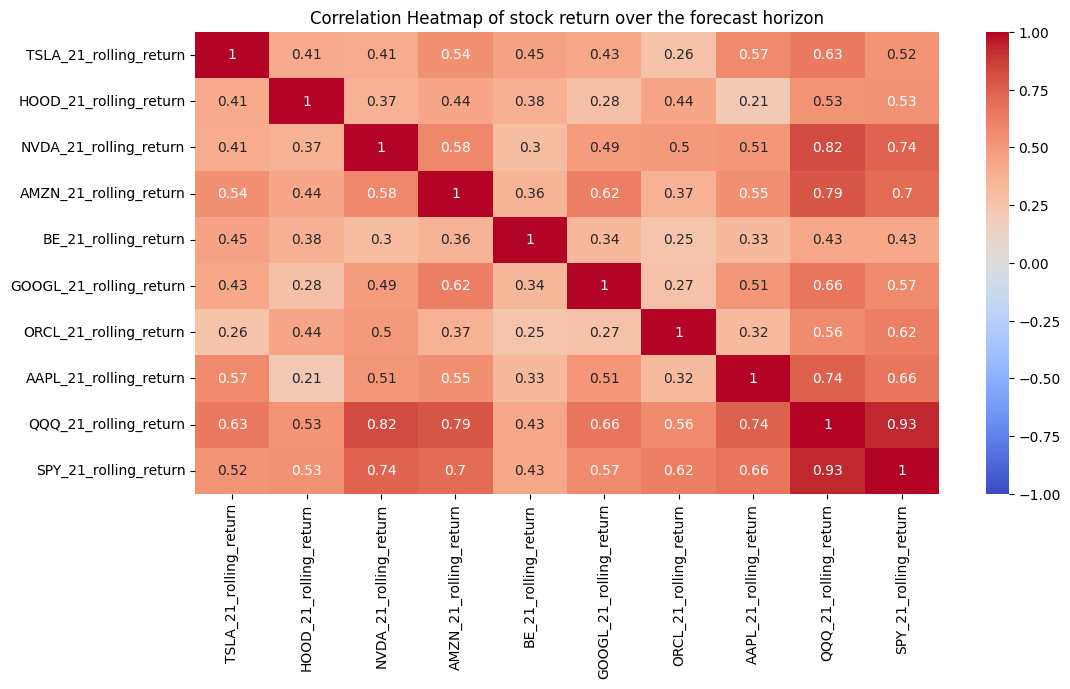

In [22]:
plt.figure(figsize=(12, 6))

heatmap = sns.heatmap(df[['TSLA_21_rolling_return', 'HOOD_21_rolling_return', 'NVDA_21_rolling_return', 'AMZN_21_rolling_return', 'BE_21_rolling_return', 'GOOGL_21_rolling_return', 'ORCL_21_rolling_return', 'AAPL_21_rolling_return', 'QQQ_21_rolling_return', 'SPY_21_rolling_return']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
heatmap.set_title('Correlation Heatmap of stock return over the forecast horizon')
plt.show()

### 1.4 Cumulative returns of the assets in the portfolio over the evalutation period

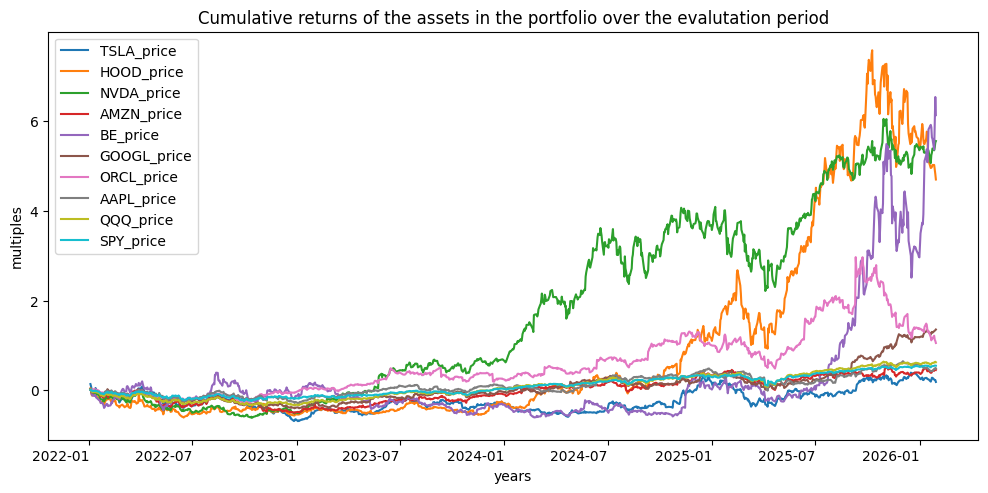

In [23]:
((df[['TSLA_price', 'HOOD_price', 'NVDA_price', 'AMZN_price', 'BE_price', 'GOOGL_price', 'ORCL_price', 'AAPL_price', 'QQQ_price','SPY_price']].pct_change()['2022':] + 1).cumprod()-1).plot(figsize=(12,6), colormap='tab10', xlabel='years',ylabel='multiples',rot=0)
plt.title('Cumulative returns of the assets in the portfolio over the evalutation period')
plt.show()

![data_frame.png](pic/data_frame.png)

In [24]:
feature_df = df
X, y, assets, feature_names, dates = data.create_tensors(feature_df)
print("X shape:", X.shape) 
print("y shape:", y.shape)
print("feature_names:", feature_names)
print("assets:", assets)
print("dates:", dates)

X shape: (978, 9, 66, 9)
y shape: (978, 9)
feature_names: ['price', 'volume', 'log_ret', 'volatility', 'EMA20', 'EMA50', 'beta', 'log_vol', 'smi']
assets: ['TSLA', 'HOOD', 'NVDA', 'AMZN', 'BE', 'GOOGL', 'ORCL', 'AAPL', 'QQQ']
dates: DatetimeIndex(['2022-02-04', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11', '2022-02-14', '2022-02-15',
               '2022-02-16', '2022-02-17',
               ...
               '2025-12-15', '2025-12-16', '2025-12-17', '2025-12-18',
               '2025-12-19', '2025-12-22', '2025-12-23', '2025-12-24',
               '2025-12-26', '2025-12-29'],
              dtype='datetime64[ns]', length=978, freq=None)


In [25]:
X[0,0,0] #all feature values for TSLA ~66 days before 2022-07-14

array([ 3.90666656e+02,  1.28213400e+08, -3.07427480e-02,  4.82000000e-02,
        3.22158310e+02,  2.84738108e+02,  8.94900000e-01,  1.86692066e+01,
        8.03556849e-01])

In [26]:
y[0] #target 21 days after 2022-07-14 rolling return for all 9 asset

array([-0.11332011, -0.25612555, -0.12238371, -0.14754929,  0.50745152,
       -0.11988167, -0.11309033, -0.09071482, -0.10182553])

## 2. Build the Variational LSTM Model

### 2.1 Define the Variational LSTM Model

**1. NLL (Gaussian negative log-likelihood)**  
Per-sample NLL under a Gaussian predictive distribution with mean $\hat{\mu}$ and log-variance $\log \hat{\sigma}^2$:
\begin{align*}
\text{NLL}_i &= \frac{1}{2} \log \hat{\sigma}^2_i + \frac{1}{2} \frac{(y_i - \hat{\mu}_i)^2}{\hat{\sigma}^2_i}\\ 
&= \frac{1}{2} \hat{s}_i + \frac{1}{2} \frac{(y_i - \hat{\mu}_i)^2}{e^{\hat{s}_i}}
\end{align*}

where $\hat{s}_i = \log \hat{\sigma}^2_i$ is the model’s predicted log-variance. This penalizes prediction error and rewards appropriate uncertainty (high $\hat{\sigma}^2$ when error is large).

**2. Weighted NLL (time-weighted)**  
Recent samples are up-weighted via exponential decay in “age”:

$$w_i = \exp\left(-\lambda \,\frac{\text{age}_i}{\max_k \text{age}_k}\right)$$

$$\text{weighted\_nll} = \frac{1}{N} \sum_i w_i \cdot \text{NLL}_i$$

with $\lambda = \texttt{recency\_weight}$ (default 2.0).

**3. KL loss (latent regularizer)**  
KL divergence from the approximate posterior $q(z \mid x)$ to the prior $p(z) = \mathcal{N}(0, I)$ (diagonal Gaussian):

$$\text{kl\_loss} = -\frac{1}{2} \frac{1}{N} \sum_i \sum_d \left( 1 + \log \sigma_{d,i}^2 - \mu_{d,i}^2 - \sigma_{d,i}^2 \right)$$

where $z \sim \mathcal{N}(\mu, \operatorname{diag}(\sigma^2))$ is the latent from the encoder. This keeps the latent from straying too far from the prior.

**4. Direction loss**  
Penalizes sign mismatch between target $y$ and predicted mean $\hat{\mu}$:

$$\text{sign\_mismatch}_i = -\tanh(y_i) \cdot \tanh(\hat{\mu}_i)$$

$$\text{loss\_direction} = \frac{1}{N} \sum_i \max(0, \text{sign\_mismatch}_i)$$

So only opposite-sign pairs ($y_i \hat{\mu}_i < 0$) add to the loss.

**5. Total loss (training objective)**  

$$\mathcal{L} = \underbrace{\overline{\text{weighted\_nll}}}_{\text{time-weighted NLL}} + \beta \cdot \underbrace{\overline{\text{kl\_loss}}}_{\text{KL regularizer}} + 0.5 \cdot \underbrace{\text{loss\_direction}}_{\text{direction penalty}}$$

with $\beta$ controlling the strength of the KL term (default 0.02).

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K, optimizers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon #reparameterization trick

class VariationalLSTM(tf.keras.Model):
    def __init__(self, input_dim, latent_dim=16, hidden_dim=32, beta=0.02, recency_weight=2.0, **kwargs):
        super(VariationalLSTM, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.beta = beta
        self.recency_weight = recency_weight #exponential decay for time-weighted loss

        #Encoder
        self.lstm = layers.LSTM(hidden_dim, return_sequences=False)
        self.z_mean = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")
        self.z_sampling = Sampling()

        # Decoder
        # Predicts mean return and log variance of return
        self.decoder_hidden = layers.Dense(hidden_dim, activation="relu")
        self.return_mean = layers.Dense(1, name="return_mean")
        self.return_log_var = layers.Dense(1, name="return_log_var") # Predict log variance for stability
        
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
    def call(self, inputs):
        h = self.lstm(inputs)  # Shape: (batch, hidden_dim), this gives us the hidden layer
        z_mean = self.z_mean(h) # Predicts: μ = f₁(h) where f₁ is learned
        z_log_var = self.z_log_var(h) # Predicts: log(σ²) = f₂(h) where f₂ is learned
        z = self.z_sampling([z_mean, z_log_var]) # z ~ N(μ, σ²)

        # Reconstruction / Prediction
        d = self.decoder_hidden(z)
        pred_return_mean = self.return_mean(d)
        pred_return_log_var = self.return_log_var(d)

        # KL Loss (will be computed in train_step, to see how close our predicted return distribution is compare to the real distribution
        # and this is what makes z_mean the mean and z_log_var the variance)
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
        )
        self.kl_loss_tracker.update_state(kl_loss) 

        return pred_return_mean, pred_return_log_var, kl_loss
    
    @property
    def metrics(self):
        return [self.kl_loss_tracker]
    
    def train_step(self, data):
        # Custom training step to handle the specific loss structure
        # Our y_pred is (pred_return_mean, pred_return_log_var, kl_loss)

        if isinstance(data, (list, tuple)) and len(data) == 3:
            x, y, sample_age = data
        else:
            x, y = data
            sample_age = tf.zeros(tf.shape(y)[0])
        
        sample_age = tf.cast(sample_age, tf.float32)
        # Ensure y has consistent dtype with model output
        y = tf.cast(y, tf.float32)

        with tf.GradientTape() as tape: 
            y_pred_return_mean, y_pred_return_log_var, kl_loss = self(x, training=True)
            # clip y_pred_log_var to avoid loss_nll overflow
            y_pred_return_log_var = tf.clip_by_value(y_pred_return_log_var, -10.0, 10.0)
            
            # Loss components

            # Gaussian Negative Log-Likelihood 
            # Penalizes error and rewards correct uncertainty
            # High-confidence wrong predictions are penalized more; low-confidence predictions are penalized less
            loss_nll = 0.5 * y_pred_return_log_var + 0.5 * tf.square(y - y_pred_return_mean) / tf.exp(y_pred_return_log_var)

            # Directional loss: penalize sign mismatch between prediction and target
            loss_direction = -tf.tanh(y) * tf.tanh(y_pred_return_mean) #negative value if same direction, positive if differ
            loss_direction = tf.reduce_mean(tf.maximum(0.0, loss_direction)) #only penalize if different direction

            # Time-weighted loss: emphasize recent samples
            max_age = tf.reduce_max(sample_age)
            max_age = tf.maximum(max_age, tf.constant(1e-6, dtype=sample_age.dtype))  # Avoid divide by zero
            time_weights = tf.exp(-self.recency_weight * sample_age / max_age) #Older samples get lower weights
            time_weights = tf.cast(time_weights, loss_nll.dtype)

            weighted_nll = loss_nll * tf.expand_dims(time_weights, axis=-1)
            total_loss = ( 
                tf.reduce_mean(weighted_nll)
                + self.beta * tf.reduce_mean(kl_loss)
                + 0.5 * loss_direction
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "total_loss": total_loss,
            "nll": tf.reduce_mean(loss_nll),
            "kl": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x,y = data
        y = tf.cast(y, tf.float32)
        y_pred_return_mean, y_pred_return_log_var, kl_loss = self(x, training=False)

        # Negative Log Likelihood Loss
        loss_nll = 0.5 * y_pred_return_log_var + 0.5 * tf.square(y - y_pred_return_mean) / tf.exp(y_pred_return_log_var)
        loss_nll = tf.reduce_mean(loss_nll)

        # Directional loss: penalize sign mismatch between prediction and target
        sign_mismatch = -tf.tanh(y) * tf.tanh(y_pred_return_mean)
        loss_direction = tf.reduce_mean(tf.maximum(0.0, sign_mismatch))

        # Total loss = NLL + KL
        # kl_loss is per-sample, reduce to scalar
        kl_loss_scalar = tf.reduce_mean(kl_loss)
        total_loss = loss_nll + self.beta * kl_loss_scalar + 0.5 * loss_direction

        return {
            "loss": total_loss,
            "nll": loss_nll,
            "kl": self.kl_loss_tracker.result(),
            "direction": loss_direction
        }

### 2.2 Training the prediction model (predict the stock return and volatility over the forecast horizon)


train and test data split

In [28]:
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K, optimizers

n_features = X.shape[3]
x_flat = X.reshape(-1, LOOKBACK, n_features)
y_flat = y.reshape(-1)

#split into train and test
n_train = int(0.8 * len(x_flat))

### 2.3 Training the allocation model


**1. Covariance matrix**  
$$\hat{H} = D \, \Sigma_{\text{corr}} \, D$$

with $D = \operatorname{diag}(\hat{H}_1, \ldots, \hat{H}_n)$ (predicted volatilities from the model) and $\Sigma_{\text{corr}}$ the sample correlation of asset returns over a lookback window (e.g. 60 days).

**2. Portfolio return and volatility**  
For weights $w \in \mathbb{R}^n$ and expected returns $\mu$:

$$\mu_p = w^\top \mu, \qquad \sigma_p = \sqrt{w^\top \hat{H} w}$$

**3. Max-drawdown proxy**  
Max drawdown over the horizon is approximated from volatility:

$$\widehat{\text{MDD}} = \max\left(\epsilon,\; 2 \sqrt{\texttt{forecast\_horizon}} \,\sigma_p\right)$$

$\texttt{forecast\_horizon}$ is the date we look forward to predict the portfolio return and volatility. $\epsilon = 10^{-4}$ to handle the case when $\sigma_p \approx 0$.

**4. Objective (ratio to maximize)**  
The *ratio* combines return vs. drawdown and an extra return term:

- If $\mu_p > 0$:  
  $$\text{ratio} = \frac{\mu_p}{\widehat{\text{MDD}}} + \alpha \,\mu_p$$  
  we favor higher return and lower drawdown; $\alpha \,\mu_p$ adds a direct return incentive.

- If $\mu_p \leq 0$:  
  $$\text{ratio} = \mu_p \,\sqrt{\texttt{forecast\_horizon}} \cdot \widehat{\text{MDD}}$$  
  then worse (more negative) return or higher drawdown is penalized.

**5. Optimization problem**  
We *minimize* $-\text{ratio}$ (equivalent to *maximizing* ratio):

$$\min_{w} \;\; -\text{ratio}(w)$$
$$\text{s.t.} \quad \sum_{j=1}^{n} w_j = 1, \quad 0 \leq w_j \leq 1$$

Implemented with SLSQP: long-only, fully invested weights; $\texttt{alpha}$ controls the trade-off between return/drawdown and raw return.

In [29]:
from scipy.optimize import minimize

class PortfolioOptimizer:
    def __init__(self, forecast_horizon: int = FORECAST_HORIZON, learning_rate: float = 0.01, alpha: float = 0.2):
        self.forecast_horizon = forecast_horizon    
        self.learning_rate = learning_rate
        self.alpha = alpha
    def convariance_matrix(self, predicted_vols, historical_correlation):
        """
        Construct the covariance matrix from the predicted volatilities and historical correlation
        """
        D = np.diag(predicted_vols)
        sigma_hat = D @ historical_correlation @ D
        return sigma_hat
        
    def objective_ratio(self, weights, expected_returns, sigma_hat):
        """
        Calculate the return over max drawdown ratio (with positive return incentive and negative drawdown penalty) of the portfolio
        """
        portfolio_return = np.sum(weights * expected_returns)
        # we use the volitility to estimate the maximum drawdown in the future
        port_vol = float(np.sqrt(weights.T @ sigma_hat @ weights))
        max_dd = max(1e-4, 2.0 * np.sqrt(self.forecast_horizon) * port_vol)

        if portfolio_return > 0:
            ratio = portfolio_return / max_dd + self.alpha * portfolio_return
        else:
            ratio = portfolio_return * np.sqrt(self.forecast_horizon) * max_dd

        return -ratio 

    def optimize_portfolio(self, predicted_returns, covariance_matrix):
        """
        Optimize the portfolio allocation based on the predicted returns, volatilities, and covariance matrix
        """
        n_assets = len(predicted_returns)
        initial_weights = np.ones(n_assets) / n_assets
        # Constraints: sum(w) = 1
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # Bounds: 0 <= w <= 1
        bounds = tuple((0.0, 1.0) for _ in range(n_assets))

        allocation = minimize(self.objective_ratio, 
                        initial_weights, 
                        args=(predicted_returns, covariance_matrix), 
                        method='SLSQP', 
                        bounds=bounds, 
                        constraints=constraints)
        
        return allocation.x
        

### 2.4 Sharpe ratio

$$S = \alpha \cdot \frac{\mathbb{E}[R_p - R_f]}{\sigma_p} = \sqrt{252} \cdot \frac{\bar{R}_p - R_f}{\sigma_p}$$

where:
- $R_p$: portfolio return
- $R_f$: risk-free rate
- $\sigma_p$: standard deviation of portfolio (excess) returns
- $\alpha = \sqrt{252}$: annualization factor

In [30]:
# Use risk-free rate = 0 for simplicity (annualized Sharpe: sqrt(252) * mean / std)
def calc_sharpe(returns):
    return np.sqrt(252) * np.mean(returns) / np.std(returns)

### 2.5 Hyperparameter tunning

In [31]:
import tensorflow as tf
from tensorflow.keras import optimizers
import optuna

# Time-blocked split with embargo to avoid leakage
n_total = len(dates)
train_end = int(0.8 * n_total)
embargo = FORECAST_HORIZON
val_start = min(train_end + embargo, n_total - 1)


def objective(trial):
    tf.keras.utils.set_random_seed(42 + trial.number)
    tf.keras.backend.clear_session()

    if val_start >= n_total - 1:
        return -999.0

    batch_size = trial.suggest_categorical("batch_size", [64, 128, 512, 1024])
    n_epochs = trial.suggest_int("epochs", 100, 2000, step=50)
    hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256, 512])
    latent_dim = trial.suggest_categorical("latent_dim", [64, 128, 256])
    lr = trial.suggest_float("learning_rate", 0.0001, 0.005, log=True)
    beta = trial.suggest_float("beta", 0.01, 0.1, step=0.01)

    model = VariationalLSTM(
        input_dim=n_features,
        latent_dim=latent_dim,
        hidden_dim=hidden_dim,
        beta=beta,
        recency_weight=2.0,
    )
    model.compile(optimizer=optimizers.Adam(learning_rate=lr))
    model.fit(
        x_flat[:train_end], y_flat[:train_end],
        validation_data=(x_flat[val_start:], y_flat[val_start:]),
        epochs=n_epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", mode="min", patience=5, restore_best_weights=True
            )
        ],
    )

    optimizer_obj = PortfolioOptimizer()
    asset_ret_cols = [f"{a}_log_ret" for a in assets]

    capital = 1.0
    portfolio_values_list = []
    current_weights = np.ones(len(assets)) / len(assets)

    for t in range(val_start, n_total):
        current_date = dates[t]
        is_month_start = (t == val_start) or (dates[t - 1].month != current_date.month)

        if is_month_start:
            X_curr = X[t]  # shape: (n_assets, lookback, n_features)
            pred_mean, pred_log_var, _ = model(X_curr, training=False)
            predicted_returns = pred_mean.numpy().flatten()
            pred_vols = np.exp(0.5 * pred_log_var.numpy().flatten())

            date_loc = feature_df.index.get_loc(current_date)
            past_60_start = max(0, date_loc - 60)
            past_60_df = feature_df.iloc[past_60_start:date_loc]
            if len(past_60_df) >= 2:
                hist_corr = past_60_df[asset_ret_cols].corr().values
            else:
                hist_corr = np.eye(len(assets))

            sigma_hat = optimizer_obj.convariance_matrix(pred_vols, hist_corr)
            current_weights = optimizer_obj.optimize_portfolio(predicted_returns, sigma_hat)

        actual_daily_returns = feature_df.loc[current_date, asset_ret_cols].values
        portfolio_ret = np.sum(current_weights * actual_daily_returns)
        capital *= np.exp(portfolio_ret)
        portfolio_values_list.append(capital)

    if len(portfolio_values_list) < 2 or portfolio_values_list[-1] <= 0:
        return -999.0

    portfolio_daily_returns = np.diff(np.log(np.array(portfolio_values_list)))
    portfolio_sharpe = calc_sharpe(portfolio_daily_returns)
    if not np.isfinite(portfolio_sharpe):
        return -999.0

    return float(portfolio_sharpe)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best Sharpe (validation):", study.best_value)

[I 2026-02-01 20:25:15,118] A new study created in memory with name: no-name-c68469b7-6fae-4220-939a-1678f1c2c8e5
[I 2026-02-01 20:25:54,258] Trial 0 finished with value: 1.3216530416621677 and parameters: {'batch_size': 128, 'epochs': 850, 'hidden_dim': 256, 'latent_dim': 256, 'learning_rate': 0.0009667947840958333, 'beta': 0.09999999999999999}. Best is trial 0 with value: 1.3216530416621677.
[I 2026-02-01 20:27:24,419] Trial 1 finished with value: 1.9541600918510365 and parameters: {'batch_size': 512, 'epochs': 200, 'hidden_dim': 256, 'latent_dim': 64, 'learning_rate': 0.00011360296682199247, 'beta': 0.01}. Best is trial 1 with value: 1.9541600918510365.
[I 2026-02-01 20:28:22,484] Trial 2 finished with value: 2.6998432548928304 and parameters: {'batch_size': 512, 'epochs': 1250, 'hidden_dim': 256, 'latent_dim': 128, 'learning_rate': 0.0006210253701373365, 'beta': 0.03}. Best is trial 2 with value: 2.6998432548928304.
[I 2026-02-01 20:29:14,919] Trial 3 finished with value: 3.0610782

Best hyperparameters: {'batch_size': 1024, 'epochs': 2000, 'hidden_dim': 512, 'latent_dim': 256, 'learning_rate': 0.00016626996520281164, 'beta': 0.04}
Best Sharpe (validation): 4.319447022750583


In [32]:
#Tuned parameters
BATCH_SIZE = study.best_params['batch_size']
EPOCHS = study.best_params['epochs']
LEARNING_RATE = study.best_params['learning_rate']
HIDDEN_DIM = study.best_params['hidden_dim']
LATENT_DIM = study.best_params['latent_dim']
beta = study.best_params['beta']

run the model with the tuned parameters

In [33]:
model = VariationalLSTM(input_dim=n_features, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, beta=beta, recency_weight=2.0)
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE))

history = model.fit(x_flat[:n_train], y_flat[:n_train], validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE)

#evaluate on test set
print("Evaluating on test set...")
test_loss = model.evaluate(x_flat[n_train:], y_flat[n_train:])



Epoch 1/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 693ms/step - kl: 0.2019 - nll: 0.3557 - total_loss: 0.3775 - val_direction: 0.0153 - val_kl: 0.1958 - val_loss: 0.1494 - val_nll: 0.1339
Epoch 2/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 625ms/step - kl: 0.1929 - nll: 0.1317 - total_loss: 0.1489 - val_direction: 0.0269 - val_kl: 0.1899 - val_loss: 0.0747 - val_nll: 0.0537
Epoch 3/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 624ms/step - kl: 0.1898 - nll: -0.1536 - total_loss: -0.1371 - val_direction: 0.0143 - val_kl: 0.1905 - val_loss: -0.2428 - val_nll: -0.2576
Epoch 4/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 624ms/step - kl: 0.1926 - nll: -0.3334 - total_loss: -0.3184 - val_direction: 0.0168 - val_kl: 0.1983 - val_loss: -0.3688 - val_nll: -0.3852
Epoch 5/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 617ms/step - kl: 0.2033 - nll: -0.4292 - total_loss: -0.4143 - val_direction: 0.0159 - val_kl: 0.2116 - val_loss: -0.4473 - val_nll: -0.4637
Epoch 6/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 616ms/step - kl: 0.2177 - nll: -0.5879 - total_loss: -0.5

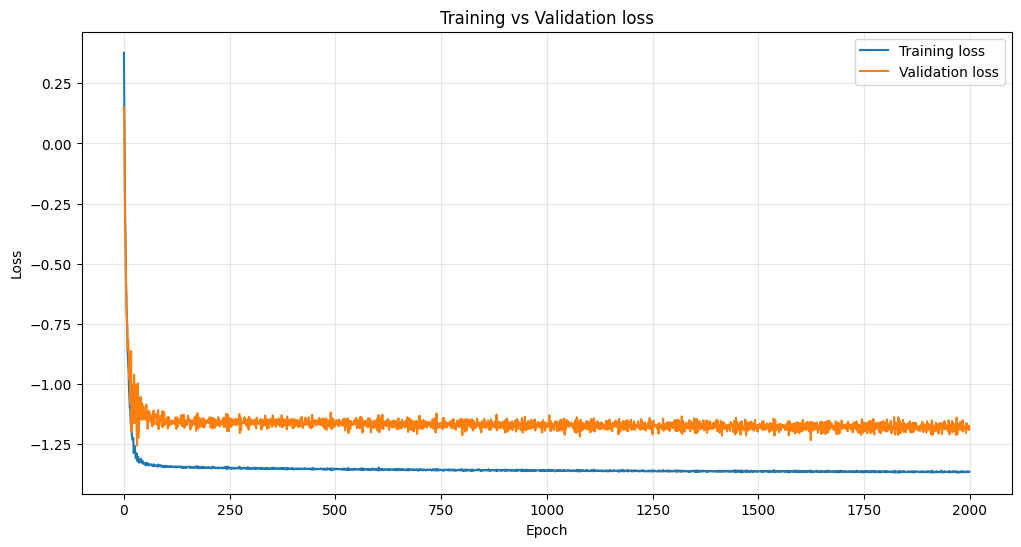

In [34]:
#plot training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['total_loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation loss')
plt.grid(True, alpha=0.3)
plt.show()

### 2.6 Monthly rebalanced backtest

![monthly_allocation_logic.png](pic/monthly_allocation_logic.png)

**Figure** Monthly allocation logic

**Backtest logic (monthly rebalance)**

We loop over each date in the backtest window. On **month-start** dates we rebalance (predict → covariance → optimize). **Every day** we apply current weights to that day's returns and compound capital. No look-ahead: correlation uses only the past 60 days; predictions use data up to `current_date`.

---

**1. Initialization**
- Capital $C_0 = 1$; equal weights $w_0 = (1/n, \ldots, 1/n)$.
- Dates: same as `dates` from `create_tensors`.

**2. Rebalance (month start only)**  
Trigger: first date ($t=0$) or when the calendar month changes ($\texttt{month}_{t-1} \neq \texttt{month}_t$).
- **Predict:** Input $X_t$ (shape: assets $\times$ lookback $\times$ features) → model outputs mean log-return $\hat{\mu}$ and log-variance $\log \hat{\sigma}^2$ per asset.
- **Volatilities:** $\hat{\sigma}_j = \exp(0.5 \cdot \log \hat{\sigma}^2_j)$.
- **Correlation:** Past 60 trading days of actual log returns (strictly before `current_date`) → sample correlation matrix $\Sigma_{\text{corr}}$.
- **Covariance:** $\hat{\Sigma} = D \Sigma_{\text{corr}} D$ with $D = \operatorname{diag}(\hat{\sigma}_1, \ldots, \hat{\sigma}_n)$.
- **Weights:** Solve return vs. max-drawdown → $w_t$; hold until next month start.

**3. Daily P&amp;L (every date)**  
Using current weights $w_t$ (fixed since last rebalance):
- Actual log-returns: $r_{j,t}$ from `feature_df.loc[current_date, asset_ret_cols]`.
- Portfolio log-return: $R_{p,t} = \sum_j w_{j,t} r_{j,t}$.
- Compound: $C_{t+1} = C_t \cdot \exp(R_{p,t})$.

**4. Output**
- `portfolio_values`: time series of $C_t$.
- `weights_over_time`: $w_t$ per date.

In [35]:
# Build monthly rebalanced allocations and portfolio values
optimizer = PortfolioOptimizer()
asset_ret_cols = [f"{a}_log_ret" for a in assets]

initial_capital = 1.0
portfolio_values = []
weights_over_time = []
current_capital = initial_capital
current_weights = np.ones(len(assets)) / len(assets)

for t, current_date in enumerate(dates):
    # Rebalance at month start
    is_month_start = (t == 0) or (dates[t - 1].month != current_date.month)
    if is_month_start:
        X_curr = X[t]  # shape: (n_assets, lookback, n_features)
        pred_mean, pred_log_var, _ = model(X_curr, training=False)
        predicted_returns = pred_mean.numpy().flatten()
        pred_vols = np.exp(0.5 * pred_log_var.numpy().flatten())

        date_loc = feature_df.index.get_loc(current_date)
        past_60_start = max(0, date_loc - 60)
        past_60_df = feature_df.iloc[past_60_start:date_loc]
        if len(past_60_df) >= 2:
            hist_corr = past_60_df[asset_ret_cols].corr().values
        else:
            hist_corr = np.eye(len(assets))

        sigma_hat = optimizer.convariance_matrix(pred_vols, hist_corr)
        current_weights = optimizer.optimize_portfolio(predicted_returns, sigma_hat)

    # Apply daily log return
    actual_daily_returns = feature_df.loc[current_date, asset_ret_cols].values
    portfolio_ret = np.sum(current_weights * actual_daily_returns)
    current_capital *= np.exp(portfolio_ret)

    portfolio_values.append(current_capital)
    weights_over_time.append(current_weights)

weights_over_time = pd.DataFrame(weights_over_time, index=dates, columns=assets)
portfolio_values = pd.Series(portfolio_values, index=dates, name="PortfolioValue")


# Result visualization

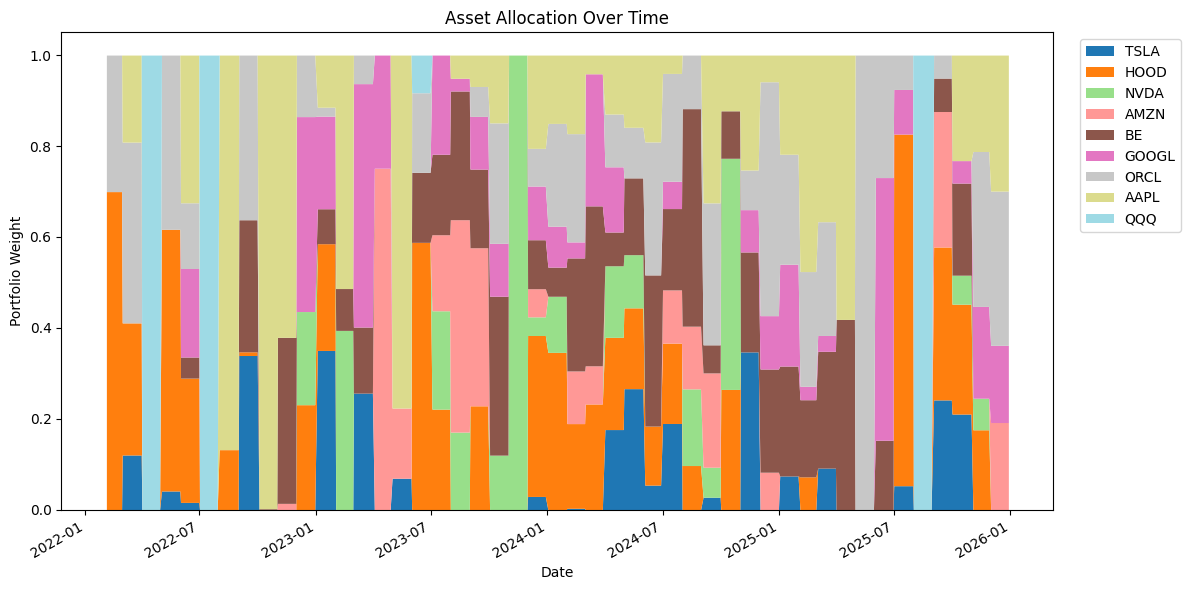

In [36]:
# Allocation over time
plt.figure(figsize=(12, 6))
weights_over_time.plot.area(stacked=True, linewidth=0, colormap="tab20", ax=plt.gca())
plt.title("Asset Allocation Over Time")
plt.ylabel("Portfolio Weight")
plt.xlabel("Date")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), ncol=1)
plt.tight_layout()
plt.show()


Portfolio Cumulative Returns vs S&P500 outperform:  254.85 %


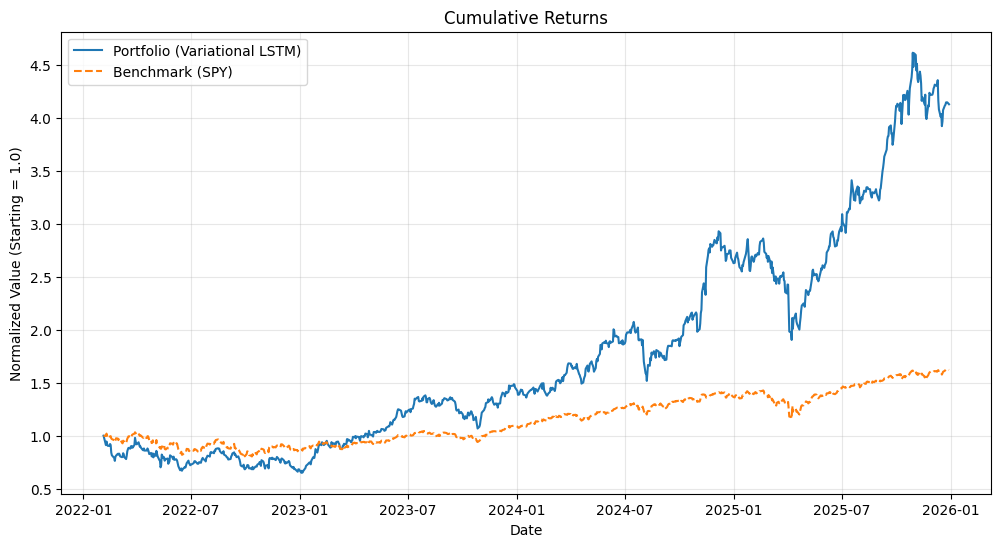

In [37]:
# Cumulative returns vs SPY benchmark
spy_log_returns = feature_df.loc[dates, "SPY_log_ret"].values
benchmark_cum = np.exp(np.cumsum(spy_log_returns))
portfolio_cum = portfolio_values.values
portfolio_cum = portfolio_cum / portfolio_cum[0]
benchmark_cum = benchmark_cum / benchmark_cum[0]

print("Portfolio Cumulative Returns vs S&P500 outperform: ", round(portfolio_cum[-1]/benchmark_cum[-1] *100, 2), "%")

plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_cum, label="Portfolio (Variational LSTM)")
plt.plot(dates, benchmark_cum, label="Benchmark (SPY)", linestyle="--")
plt.title("Cumulative Returns")
plt.ylabel("Normalized Value (Starting = 1.0)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [38]:
# Calculate daily returns for Sharpe Ratio (log returns, so differences are fine)
portfolio_daily_returns = np.diff(np.log(portfolio_values.values))
spy_daily_returns = np.diff(np.log(benchmark_cum))

portfolio_sharpe = calc_sharpe(portfolio_daily_returns)
spy_sharpe = calc_sharpe(spy_daily_returns)

print(f"Sharpe Ratio (Portfolio): {portfolio_sharpe:.3f}")
print(f"Sharpe Ratio (S&P 500):   {spy_sharpe:.3f}")


Sharpe Ratio (Portfolio): 0.963
Sharpe Ratio (S&P 500):   0.694


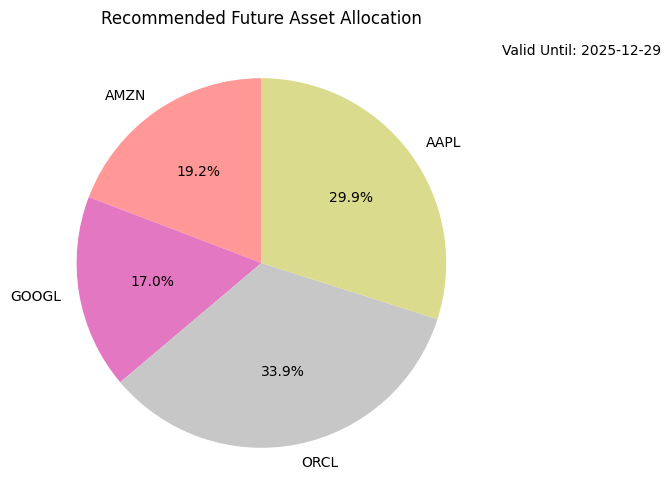

In [39]:
# Future allocation pie chart (last available date)
last_date = dates[-1]
last_alloc = weights_over_time.iloc[-1]
last_alloc = last_alloc[last_alloc > 0.001]

# Same ticker → same color as in the allocation-over-time area plot (colormap="tab20")
asset_order = list(weights_over_time.columns)
tab20 = plt.get_cmap("tab20")
n_cols = len(asset_order)
norm = max(n_cols - 1, 1)
colors = [tab20(asset_order.index(a) / norm) for a in last_alloc.index]

plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    last_alloc.values, 
    labels=last_alloc.index, 
    autopct="%1.1f%%", 
    startangle=90,
    colors=colors
)
plt.title("Recommended Future Asset Allocation")
plt.annotate(
    f"Valid Until: {last_date.date()}",
    xy=(1.02, 0.95),
    xycoords="axes fraction"
)
plt.show()